In [1]:
to_train = false
to_add_proc = false
save_fig = true
include("../example/test2/test2_nn.jl")
folder = "../example/test2/";
push!(LOAD_PATH,"../src")
using ModDyn
using ModUtil: repeat_experiment
using ModTraj
using BasicInterpolators
using ModSMC
using Statistics
using StatsPlots, DataFrames

using Plots
using LaTeXStrings
using Plots.PlotMeasures

gr()

default(titlefont = (12), legendfontsize=8, 
    guidefont = (11), 
    fg_legend = :transparent)

include("plot_training.jl");

figsize = (350, 250);

# 0. Resrouces

In [2]:
Sys.cpu_info()[1].model, nprocs()

("Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz", 1)

# 1. Training result

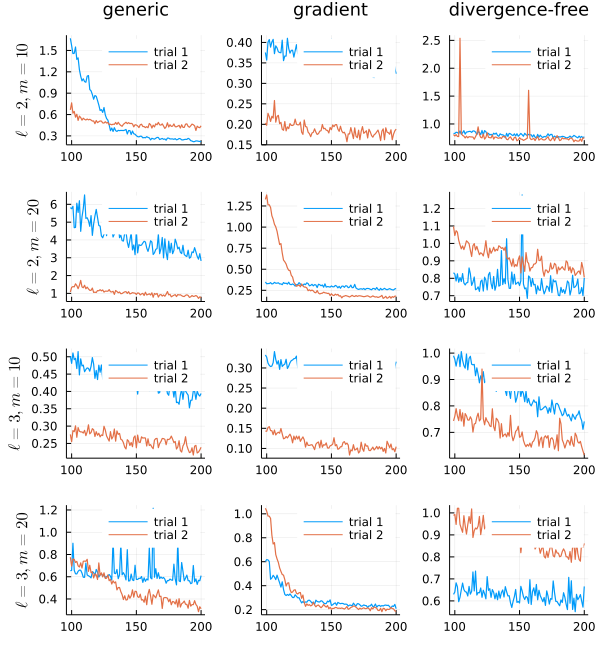

In [3]:
start_idx = 100
linewidth= 1.2

#fig_type = :err
fig_type = :var
#fig_type = :grad
#yscale=:log10
yscale=:identity

ℓm_list = [(ℓ, m) for ℓ in ℓ_list for m in m_list]
fig  = Array{Any}(undef, length(ℓm_list), length(model_list))
ansatz_list = ["generic", "gradient", "divergence-free"]

for i = 1:length(ℓm_list) 
    for j = 1:length(model_list)
        ℓ, m = ℓm_list[i]
        model_num = model_list[j]
        if j == 1 
            ylabel = L"{\bf \ell = %$(ℓ), m = %$(m)}"
        else 
            ylabel = "" 
        end
        if i == 1 
            title = ansatz_list[j] 
        else 
            title = "" 
        end
        xlabel= ""
        
        fig[i,j] = plot_error(m, ℓ, model_num, seed_list, exact_mean, folder, 
                fig_type=fig_type, start_idx = start_idx, xlabel=xlabel, ylabel=ylabel, title=title, 
                yscale=yscale, linewidth=linewidth, nolabel=false)
    end 
end    

xtic = [100,150,200]
fig_simu = plot(fig[1,1], fig[1,2], fig[1,3], 
    fig[2,1], fig[2,2], fig[2,3], 
    fig[3,1], fig[3,2], fig[3,3], 
    fig[4,1], fig[4,2], fig[4,3], 
    size=(600,650), layout=(@layout grid(4,3)),  
    xticks=(xtic,xtic))
save_fig ? savefig(fig_simu, "assets/test2_simu_"*string(fig_type)*".pdf") : nothing

fig_simu

# 2. Flow lines and sample distributions for a particular example

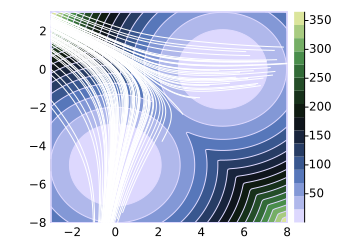

In [4]:
xmin = -3
xmax = 8
ymin = -8
ymax = 3

m = 20
ℓ = 3
model_num = 2
seed = 1

xc = range(xmin, stop=xmax, length=10^2)
yc = range(ymin, stop=ymax, length=10^2)
casename =  folder*@sprintf("case_%d_model_%d_%d_%d_%d_%d_%d_%d_training_data.jld2", 
        testcasenum, model_num, n, N, numsample_max, m, ℓ, seed)

flow = load(casename, "flow")

Random.seed!(seed)
gpts = SharedArray(randn(n, numsample_max))
U₀.sampler = (j)->gpts[:,j]

T = 1.0
t_vec = Array(range(0,stop=1.0,length=Int64(ceil(T*50))+1))
unit_step = 5
num_particle = 100
traj_gpts = [U₀.sampler(i) for i in 1:num_particle]

f1 = Plots.contour(xc, yc, (x,y)-> U₁.U([x,y]), fill=true, 
    color=:tofino, size=figsize, xlims=(xmin,xmax), ylims=(ymin,ymax),
    left_margin=20px,right_margin=20px)
plot_traj(num_particle, traj_gpts, flow, t_vec, unit_step)
save_fig ? savefig(f1, @sprintf("assets/test2_flow_%d_%d_%d_%d.pdf",model_num,ℓ,m,seed)) : nothing
f1

## Estimate the efficiency

In [5]:
Random.seed!(1)
numsample = 10^3
numrepeat = 10;
U₀.sampler = j->gpts_sampler()

function estimate_neis_efficiency(; verbose=false)

    time_neis = @elapsed data, emp_m, emp_var = get_data_err_var(U₀, U₁, flow, N, numsample_max)
    time_neis_per_sample = time_neis/length(data)
    var_neis = emp_var/exact_mean^2
    eff_neis = var_neis * time_neis_per_sample
    
    verbose ? @printf("mean %.2E\n", mean(data)/exact_mean) : nothing
    verbose ? @printf("efficiency %.2E\n", eff_neis) : nothing
    
    return time_neis, time_neis_per_sample, var_neis, eff_neis
    
end

estimate_neis_efficiency (generic function with 1 method)

In [6]:
eff_neis_vec = map(j->estimate_neis_efficiency(verbose=true)[4], 1:5)
print(eff_neis_vec)

mean 1.02E+00
efficiency 3.26E-03
mean 9.84E-01
efficiency 2.59E-03
mean 1.02E+00
efficiency 2.41E-03
mean 1.02E+00
efficiency 2.44E-03
mean 9.70E-01
efficiency 2.67E-03
[0.003, 0.003, 0.002, 0.002, 0.003]

Mean 9.93E-01 variance 2.31E-01


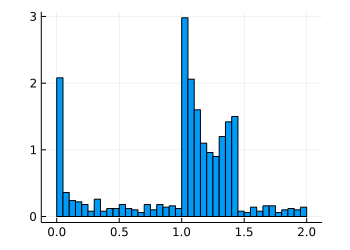

In [7]:
data, emp_m, emp_var = get_data_err_var(U₀, U₁, flow, N, numsample_max)
f2 = histogram(data/exact_mean, nbins=40, label="", normed=true, size=figsize,
    left_margin=20px,right_margin=20px)
@printf("Mean %.2E variance %.2E\n", emp_m/exact_mean, emp_var/exact_mean^2)
f2

# 3. Comparison

In [8]:
s1 = 200
s2 = 20
s3 = 1

K = 10
βlist = Array(range(0, stop=1.0, length=K+1))
τ = 0.1
fun_ais_10 = numsample->mean(map(j->ais_neal(U₀.sampler(j), n, U₀, U₁, K, βlist, τ)[1], 1:(numsample*s1)))
time_ais_10 = @elapsed data_ais_10_rep = repeat_experiment(fun_ais_10, numsample, numrepeat, gpts, gpts_sampler);

K = 100
βlist = Array(range(0, stop=1.0, length=K+1))
τ = 0.1
fun_ais_100 = numsample->mean(map(j->ais_neal(U₀.sampler(j), n, U₀, U₁, K, βlist, τ)[1], 1:(numsample*s2)))
time_ais_100 = @elapsed data_ais_100_rep = repeat_experiment(fun_ais_100, numsample, numrepeat, gpts, gpts_sampler);

#Ngd = 2*N # time-discretization; for gradient-flow only
Ngd = 5*N
Ωq = domain_ball(30);
flow_gd_1 = generate_gradient_flow(U₁, 1.0, Ωq);
fun_gd_1 = numsample-> get_data_err_var(U₀, U₁, flow_gd_1, Ngd, (numsample*s3))[2]
time_gd = @elapsed data_gd_rep_1 = repeat_experiment(fun_gd_1, numsample, numrepeat, gpts, gpts_sampler);

fun_nn = numsample -> get_data_err_var(U₀, U₁, flow, N, numsample)[2]
time_nn = @elapsed data_nn_rep = repeat_experiment(fun_nn, numsample, numrepeat, gpts, gpts_sampler);

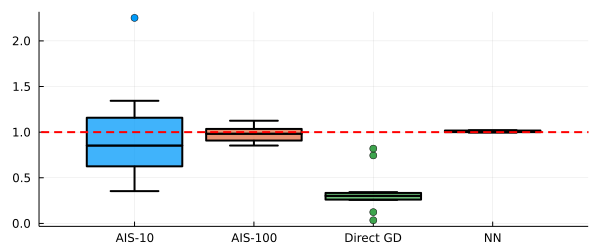

In [9]:
# boxplot
df = DataFrame(ais10=data_ais_10_rep/exact_mean, 
    ais100=data_ais_100_rep/exact_mean, 
    gd1=data_gd_rep_1/exact_mean, 
    nn=data_nn_rep/exact_mean)
fig = @df df boxplot([:ais10, :ais100, :gd1, :nn], 
    xticks = (1:1:5, ["AIS-10", "AIS-100", "Direct GD", "NN"]),
    fillalpha = 0.75, linewidth=2, label="", size=(600,250), outliers=true)
plot!(0:1:5, ones(6), linewidth=2, label="", color=:red, linestyle=:dash)
plot!(xlim=(0.2, 4.8))
save_fig ? savefig(fig, "assets/test2_compare.pdf") : nothing

fig

In [10]:
println(df)

10×4 DataFrame
 Row │ ais10    ais100   gd1      nn      
     │ Float64  Float64  Float64  Float64 
─────┼────────────────────────────────────
   1 │   2.252    0.985    0.295    1.006
   2 │   1.217    0.906    0.123    1.008
   3 │   0.980    1.125    0.309    0.999
   4 │   0.592    1.020    0.745    0.995
   5 │   1.343    0.980    0.258    0.997
   6 │   0.774    0.913    0.270    1.011
   7 │   0.354    1.097    0.342    1.021
   8 │   0.934    1.040    0.034    1.002
   9 │   0.725    0.853    0.820    1.020
  10 │   0.530    0.881    0.308    1.021


## Simulation time

In [11]:
println(time_ais_10)
println(time_ais_100)
println(time_gd)
println(time_nn)

178.163
177.124
153.818
113.318


## Efficiency of AIS-100

In [12]:
import Statistics: std

K = 100
βlist = Array(range(0, stop=1.0, length=K+1))
τ = 0.1

numsample_ais = 10^5

function estimate_ais_efficiency(; verbose=true)
    time_ais = @elapsed estimate = map(j->ais_neal(U₀.sampler(j), n, U₀, U₁, K, βlist, τ)[1], 1:(numsample_ais))
    time_per_sample = time_ais/numsample_ais
    var_ais = std(estimate, corrected=false).^2/exact_mean^2
    eff_ais_100 = time_per_sample * var_ais
    
    verbose ? @printf("Mean is %.3f\n", mean(estimate)/exact_mean) : nothing
    verbose ? println(eff_ais_100) : nothing
    
    return time_ais, time_per_sample, var_ais, eff_ais_100
end

estimate_ais_efficiency (generic function with 1 method)

In [13]:
eff_ais_100 = map(j->estimate_ais_efficiency()[4], 1:5)

Mean is 0.960
0.095
Mean is 1.006
0.255
Mean is 1.049
0.229
Mean is 1.002
0.216
Mean is 0.925
0.116


5-element Vector{Float64}:
 0.095
 0.255
 0.229
 0.216
 0.116

In [14]:
err_std = 0.01
@printf("AIS takes around %.2f hours to achieve %.2E std error\n", 
    median(eff_ais_100)/err_std^2/(3600), err_std)

AIS takes around 0.60 hours to achieve 1.00E-02 std error


# Cost ratio

In [15]:
minimum(eff_neis_vec)/maximum(eff_ais_100), maximum(eff_neis_vec)/minimum(eff_ais_100)

(0.009, 0.034)